# Time Series Clustering

## Feature extraction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


Time series can be represented in several ways, to use one or another usually depends on the domain or the application.

Here we have a raw time series from a neuro phisiology domain. Here the element that is characteristic in the series are the peaks generated by neuron activations, we can use a representation able to denoise, extract or highlight these elements.

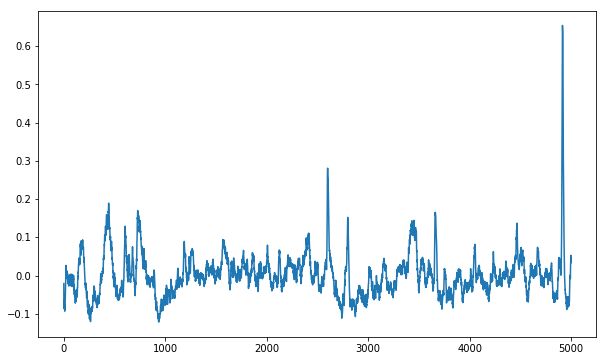

In [2]:
datapath = '../../Data/'

data = np.loadtxt(datapath+'tseries.csv')
fig = plt.figure(figsize=(10,6))
plt.plot(data);

The Fast Fourier Tranform (space of frequencies) converts the data to the range of prevalent frequencies. This transformation can be used to denoise the original data by discarding the frequencies higher of a threshold or give an idea about the range of frequencies that are interesting in the series. 

With a problem where there are a set of time series, the frequencies can give a set of characteristics that are more suitable to compare series and can transform from a dataset with examples of different length to a dataset with the same number of dimensions (a range of frequencies)

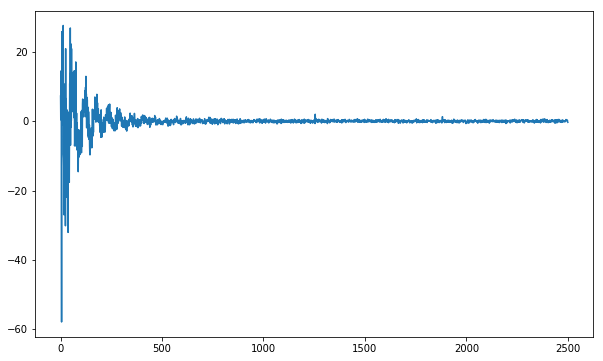

In [3]:
from numpy.fft import rfft

freq = rfft(data[0:5000])
fig = plt.figure(figsize=(10,6))
plt.plot(freq);

The **SAX** method generates a new discretized series that simplifies the comparison among series and reduces the size of the dataset.

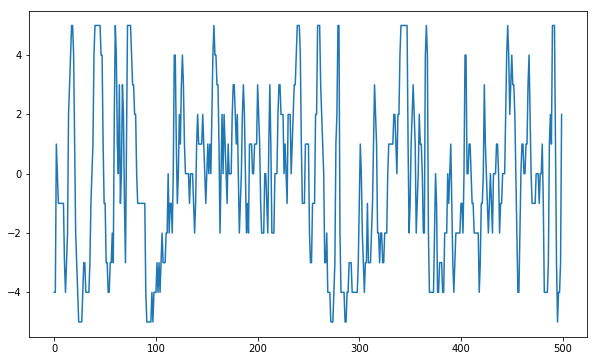

In [4]:
import kemlglearn.time_series.discretization.SAX as SAX
saxtrans = SAX(window_length=data.shape[0], word_length=500, voc_size=11)
datatrans = saxtrans.transform(data)
fig = plt.figure(figsize=(10,6))
plt.plot(datatrans[0]);

# Clustering Time Series

This data corresponds to recordings of group neuron activations from a cat's spinal cord

(60, 85)


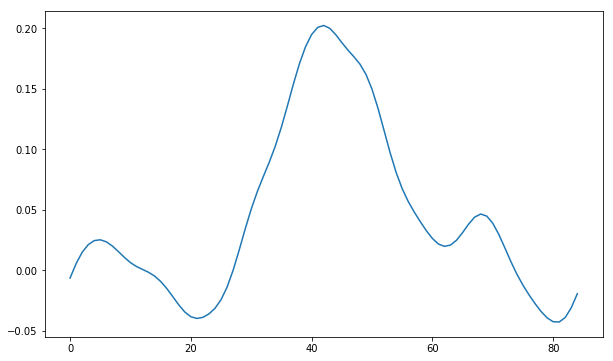

In [5]:
datapath = '../../Data/'

X = np.loadtxt(datapath+'peaks.csv', delimiter=' ')
print(X.shape)
fig = plt.figure(figsize=(10,6))
plt.plot(X[0]);

To use different distance funcions can change the kind of patterns that can be discovered.

We can cluster the set of series using K-medoids and the euclidean distance

In [6]:
from kemlglearn.cluster import KMedoidsFlexible
from scipy.spatial import distance

def sel(n, i, j):
    return n * i - (i * (i+1)//2) + (j - i) - 1

nc = 5
mdist = np.zeros(X.shape[0] * (X.shape[0] - 1) // 2)

In [7]:
%%timeit -n1 -r1
for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        mdist[sel(X.shape[0], i, j)] = distance.euclidean(X[i], X[j])

26.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
km = KMedoidsFlexible(n_clusters=nc, distance='precomputed')
labels_euc = km.fit_predict(mdist)

We decide arbitrarily to create five clusters, in this case we can see how there are some clear clusters and others that mix a variety of patterns more ore less similar among them, we get also clusters with a few examples. In this case the central peak is driving the clusters because is the most prominent part of the series, peaks of the same width and heigt will be clustered together.

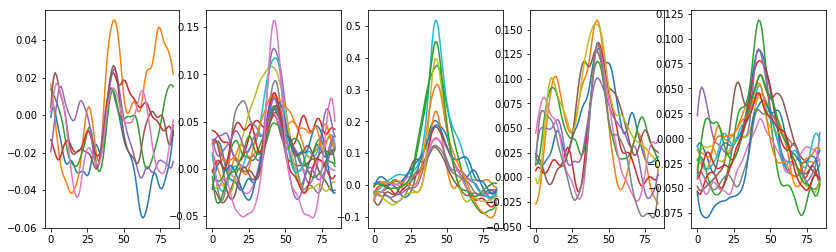

In [9]:
fig = plt.figure(figsize=(14,4))
for i in range(nc):
    ax = fig.add_subplot(1, nc, i + 1)
    for p, j in enumerate(labels_euc):
        if j == i:
            ax.plot(X[p])
plt.show();

A hierarchical cluster sees the clear separation of one small cluster and if we inspect the dendrogram we can see other four more or less clear clusters 

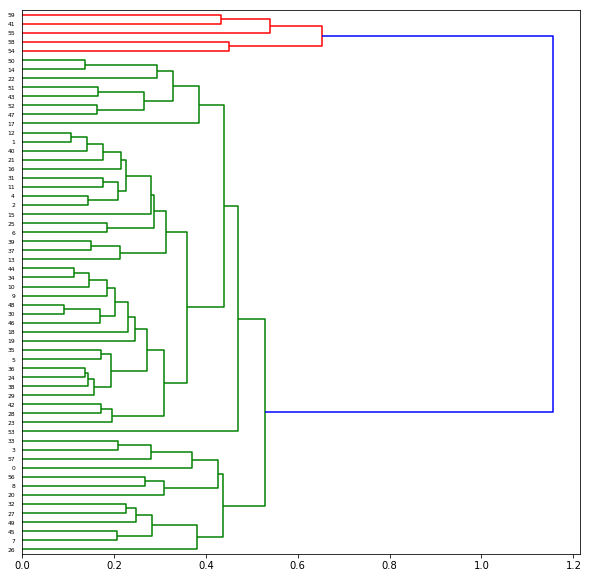

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clust = linkage(mdist, method='average')
plt.figure(figsize=(10,10))
dendrogram(clust, distance_sort=True, orientation='right');

DTW distance is able to match better the behavior of two series, so it is not driven by the central tendency of the peak. This comes at a cost obviously, the computation time increases quadratically.

Clustering of the series using K-medoids and DTW distance

In [11]:
from fastdtw import fastdtw
mdist = np.zeros(X.shape[0] * (X.shape[0] - 1) // 2)

In [12]:
%%timeit -n1 -r1
for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        mdist[sel(X.shape[0], i, j)] = fastdtw(X[i], X[j], dist=distance.euclidean)[0]

41.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Compare the running time with the one from the euclidean distance

In [13]:
km = KMedoidsFlexible(n_clusters=nc, distance='precomputed')
labels_dtw = km.fit_predict(mdist)

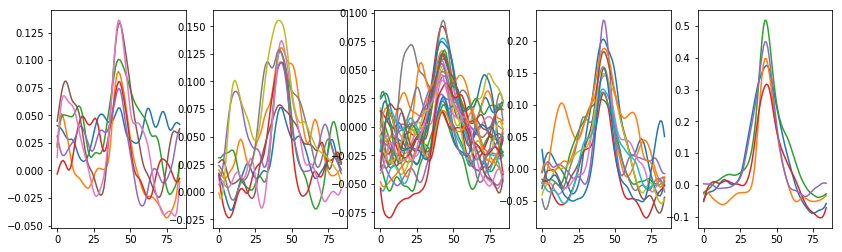

In [14]:
fig = plt.figure(figsize=(14,4))
for i in range(nc):
    ax = fig.add_subplot(1, nc, i + 1)
    for p, j in enumerate(labels_dtw):
        if j == i:
            ax.plot(X[p])
plt.show();

We also use five clusters. In this case we group the series more closely to their global behavior, the messy series are clustered more or less together and are more similar to each other.

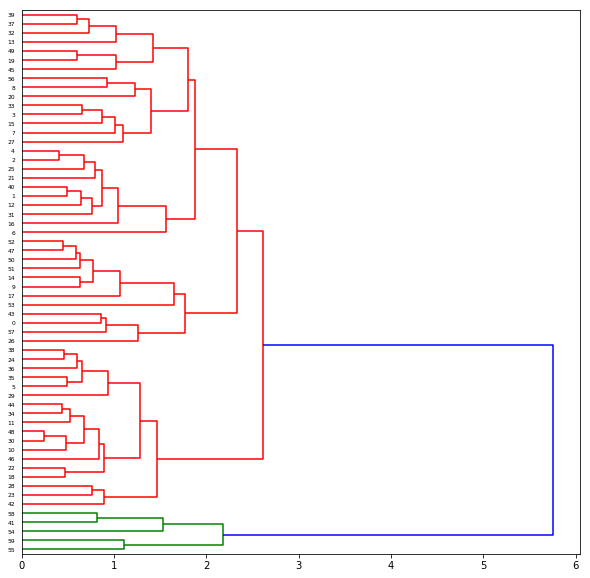

In [15]:
clust = linkage(mdist, method='average')
plt.figure(figsize=(10,10))
dendrogram(clust, distance_sort=True, orientation='right');

In this case the dentrogram seems more messy, there is one clear cluster, but it is more difficult to cut the dentrogram.

Now we are going to use the **SAX** representation to perform clustering, this will reduce the dimensionality of the series and simplify the shapes of the peaks. We arbitrarily choose a word length of 20 and a vocabulary with 9 symbols. You can see below how the series from the beggining of this sections is transformed.

(60, 20)


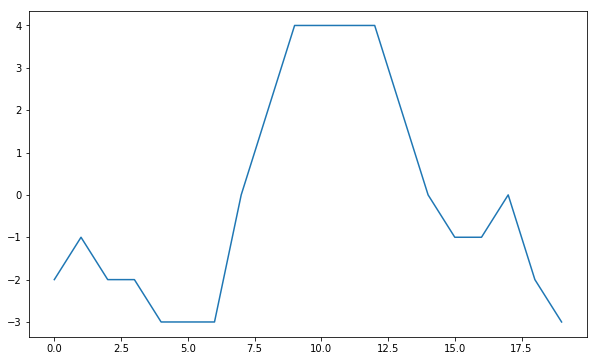

In [16]:
tmp = []

wordl= 20
saxtrans = SAX(window_length=X.shape[1], word_length=wordl, voc_size=9)
SAXX = np.zeros((X.shape[0],wordl))
for i in range(X.shape[0]):
    SAXX[i,:] =saxtrans.transform(X[i])[0]

print(SAXX.shape)
fig = plt.figure(figsize=(10,6))
plt.plot(SAXX[0]);

Now we apply K-medoids  to the dataset using euclidean distance using SAX, we will not see much of a speed up because the computations are vectorized and the length of the original series is not that long.

In [17]:
mdist = np.zeros(X.shape[0] * (X.shape[0] - 1) // 2)

In [18]:
%%timeit -n1 -r1
for i in range(SAXX.shape[0]):
    for j in range(i+1, SAXX.shape[0]):
        mdist[sel(SAXX.shape[0], i, j)] = distance.euclidean(SAXX[i], SAXX[j])

27.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
km = KMedoidsFlexible(n_clusters=nc, distance='precomputed')
labels_saxeuc = km.fit_predict(mdist)

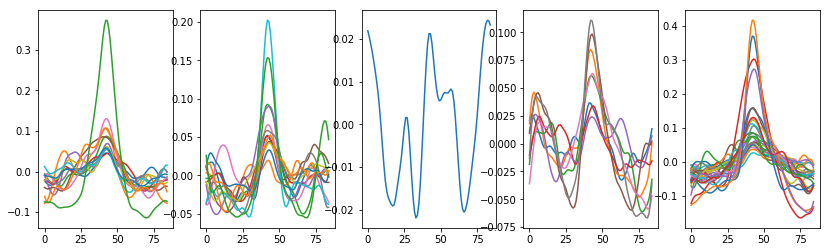

In [20]:
fig = plt.figure(figsize=(14,4))
for i in range(nc):
    ax = fig.add_subplot(1, nc, i + 1)
    for p, j in enumerate(labels_saxeuc):
        if j == i:
            ax.plot(X[p])
plt.show();

It is difficult to judge if this clustering is better, but perhaps the series in the clusters seem more similar and less mixed.

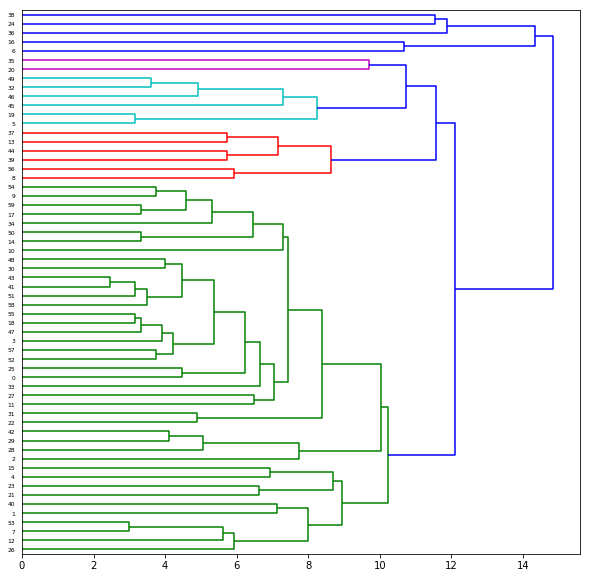

In [21]:
clust = linkage(mdist, method='average')
plt.figure(figsize=(10,10))
dendrogram(clust, distance_sort=True, orientation='right');

Now is less difficult for hierarchical clustering to detect clusters in the data. Simplifying the data we have obtained data that makes more sense for this algorithm.